# TP4 - Facial Expression Recognition / KNN
<table style="margin-left: 0px; margin-top: 20px; margin-bottom: 20px;">
<tr>
<td style="width:120px; padding-top: 10px; padding-bottom: 10px;"><img src="assets/logo_ipparis.png" style="height: 130px;"></td>
<td style="padding-left: 12px;">
<table style="width: 100%;">
<tr>
<th style="text-align: left; width: 80px;">File</th>
<td style="text-align: left;">TP4_Sara_Naranjo.ipynb</td>
</tr>
<tr>
<th style="text-align: left;">Author</th>
<td style="text-align: left;">Sara NARANJO</td>
</tr>
<tr>
<th style="text-align: left;">Affiliation</th>
<td style="text-align: left;">Institut Polytechnique de Paris &nbsp;|&nbsp; Telecom SudParis &nbsp;</td>
</tr>
<tr>
<th style="text-align: left;">Date</th>
<td style="text-align: left;">Novembre 18, 2024</td>
</tr>
<tr>
<th style="text-align: left;">Description</th>
<td style="text-align: left;">Facial Expression Recognition KNN</td>
</tr>
</table>
</td>
</tr>
</table>

# First Part: Histogram of the LBP features

## Import Necessary Libraries

In [88]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

- The code imports essential libraries for image processing, feature extraction, and machine learning.
- <b>cv2</b> (OpenCV) and <b>numpy</b> are used for image manipulation.
- <b>matplotlib.pyplot</b> is used to plot images and graphs.
- <b>local_binary_pattern</b> from <b>skimage.feature</b> is used for calculating Local Binary Pattern (LBP), a texture feature extraction technique.
- <b>train_test_split</b>, <b>KNeighborsClassifier</b>, <b>accuracy_score</b>, and <b>confusion_matrix</b> from <b>sklearn</b> are used for model training, evaluation, and performance metrics.

## Define the LBP Function

In [89]:
def lbp(image, block_size, radius):
    height, width = image.shape

    if height % block_size != 0 or width % block_size:
        print("Make sure block size is a divider of image size!")
        return 0

    num_it = int(height  / block_size)
    n_points = 8 * radius 

    lbp_patches = []

    for i in range(0, num_it):
        for j in range(0, num_it):
            i_index = i * block_size
            j_index = j * block_size
            patch= image[i_index:i_index + block_size, j_index:j_index + block_size]
            lbp_patch = local_binary_pattern(patch, R = radius, P = n_points)
            lbp_patch.ravel()
            lbp_hist = np.histogram(lbp_patch, 256)
            lbp_patches.extend(lbp_hist[0])

    return lbp_patches

This function calculates the LBP features for an image in blocks.

Parameters:
- <b>image:</b> The grayscale image for which we want to compute LBP features.
- <b>block_size:</b> Size of the blocks within the image.
- <b>radius:</b> Radius for the LBP calculation, which defines the neighborhood size for each pixel.

Function Logic:
- First, the function checks if the image dimensions are compatible with the block size.
- It then divides the image into smaller <b>block_size x block_size patches</b>.
- For each patch, it computes the LBP and creates a histogram of LBP values, which represents the texture distribution in that patch.
- The LBP histograms of all patches are combined to create a feature vector for the entire image.

## Set LBP Parameters and Load the Image

In [90]:
radius = 1
n_points = 8 * radius
block_size = 12

space =[]

image_path = '/Users/saranaranjo/VAR - too heavy/Robotics/TP4/archive/test/angry/PrivateTest_10131363.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = np.array(image)

<b>radius</b>, <b>n_points</b>, and <b>block_size</b> are parameters for LBP:

- <b>radius</b> controls the neighborhood size around each pixel.
- <b>n_points</b> is the number of neighbors considered in the LBP calculation.
- <b>block_size</b> specifies the size of each patch for localized LBP computation.

Image Loading:
- The specified image is loaded, converted to grayscale (since LBP requires grayscale images), and prepared for processing.

## Display the Grayscale Image

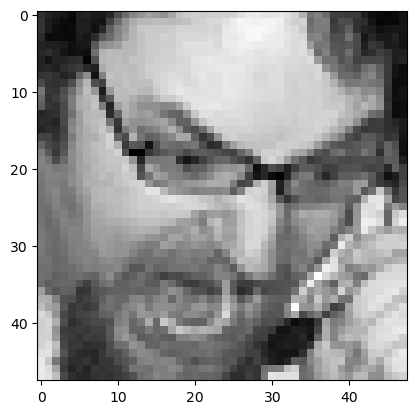

In [91]:
plt.imshow(image, cmap='gray')

This displays the grayscale image for visualization.
The <b>cmap='gray'</b> option ensures that the image is displayed in grayscale.

## Compute LBP Image 

In [92]:
# Compute LBP features using the custom function
lbp_features = lbp(image, block_size, radius)

# Compute LBP image for visualization
lbp = local_binary_pattern(image, n_points, radius, method="uniform")

The <b>local_binary_pattern</b> function calculates the LBP for the entire image, using the previously defined parameters (<b>n_points</b> and <b>radius</b>).
The <b>method="uniform"</b> option specifies that uniform LBP patterns will be used, which reduces the number of unique LBP patterns, making it more robust and compact.

## Display Grayscale Image and LBP Histogram

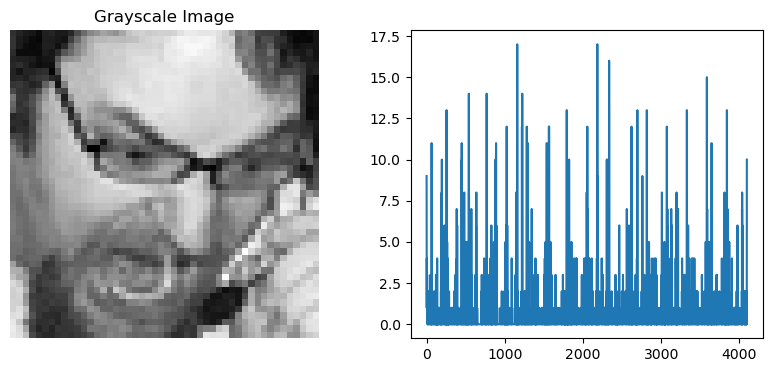

In [93]:
if lbp_features is not None:
    # Display the grayscale image
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')

    # Plot the histogram of the LBP features
    plt.subplot(1, 2, 2)
    plt.plot(lbp_features)

The grayscale image is displayed alongside the histogram of the LBP features.

Histogram of LBP Features:
The <b>plot(lbp_features)</b> command shows the distribution of LBP values.
This histogram represents the frequency of each LBP pattern in the image, capturing the image’s texture information.

## Display the LBP Image 

(-0.5, 47.5, 47.5, -0.5)

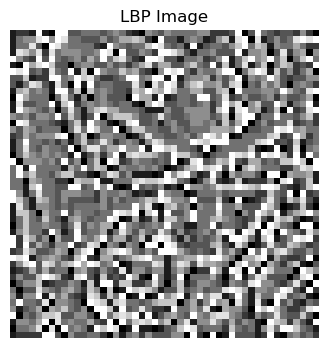

In [94]:
# Plot LBP Image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(lbp, cmap='gray')
plt.title('LBP Image')
plt.axis('off')

- The LBP-transformed image is displayed.
- This image visualizes the texture patterns, where each pixel’s intensity corresponds to the LBP value for that pixel.
- This provides an overview of the textural features that were captured by the LBP transformation.

# Second Part: Facial Expression Recognition using KNN

## Import Necessary Libraries 

In [95]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

## Set Parameters for LBP and Block Size

In [96]:
radius = 1
n_points = 8 * radius
block_size = 12

- <b>radius:</b> Determines the neighborhood radius for each pixel in the LBP calculation.
- <b>n_points:</b> Number of neighbors considered for each pixel.
- <b>block_size:</b> Size of each block when dividing the image to compute LBP histograms locally.

## Define the LBP Feature Extraction Function

In [97]:
def lbp_features(image, block_size, radius):
    height, width = image.shape
    if height % block_size != 0 or width % block_size != 0:
        return None

    num_it = int(height / block_size)
    lbp_hist = []

    for i in range(num_it):
        for j in range(num_it):
            patch = image[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
            lbp = local_binary_pattern(patch, n_points, radius, method="uniform")
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
            lbp_hist.extend(hist)

    return np.array(lbp_hist)

This function extracts LBP features for an image in a block-wise manner.
Parameters:
- <b>image:</b> Grayscale image input.
- <b>block_size:</b> Defines the size of each block in the image.
- <b>radius:</b> Controls the neighborhood size for each pixel.

Function Logic:
- Divides the image into <b>block_size x block_size</b> patches.
- Computes LBP for each patch and creates a histogram of LBP values, capturing texture information.
- Combines histograms from all patches to form the feature vector for the image.

## Load and Label Images from the Dataset

In [98]:
def load_images_from_folder(folder_path):
    data = []
    labels = []
    emotion_map = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}

    for emotion in os.listdir(folder_path):
        emotion_folder = os.path.join(folder_path, emotion)
        if os.path.isdir(emotion_folder):
            for image_name in os.listdir(emotion_folder):
                image_path = os.path.join(emotion_folder, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    features = lbp_features(image, block_size, radius)
                    if features is not None:
                        data.append(features)
                        labels.append(emotion_map[emotion])

    return np.array(data), np.array(labels)

This function loads images from a specified folder, extracts LBP features, and labels each image based on its folder.
Logic:
- Iterates over each emotion folder and each image inside.
- Reads each image, converts it to grayscale, and applies <b>lbp_features</b>.
- Appends the extracted features and corresponding label (based on the <b>emotion_map</b>) to <b>data</b> and <b>labels</b>.

## Load Training and Testing Data 

train_data, train_labels = load_images_from_folder('/Users/saranaranjo/VAR - too heavy/Robotics/TP4/archive/train')
test_data, test_labels = load_images_from_folder('/Users/saranaranjo/VAR - too heavy/Robotics/TP4/archive/test')

- Calls <b>load_images_from_folder</b> for both the training and test datasets.
- Stores the feature vectors and labels for both sets in <b>train_data</b>, <b>train_labels</b>, <b>test_data</b>, and <b>test_labels</b>.

## Train the KNN Model

In [99]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_data, train_labels)

KNeighborsClassifier(n_neighbors=3)

- Initializes a k-Nearest Neighbors classifier with <b>n_neighbors=3</b>.
- Trains the classifier on the extracted LBP features and labels from the training set.

## Evaluate the Model and Print Test Accuracy

In [100]:
predictions = knn.predict(test_data)
accuracy = accuracy_score(test_labels, predictions)
print(f"Test accuracy: {accuracy:.2f}")

Test accuracy: 0.31


- Uses the trained model to predict the labels of the test data.
- Calculates accuracy using <b>accuracy_score</b> and prints the test accuracy.

## Generate and Plot the Confusion Matrix 

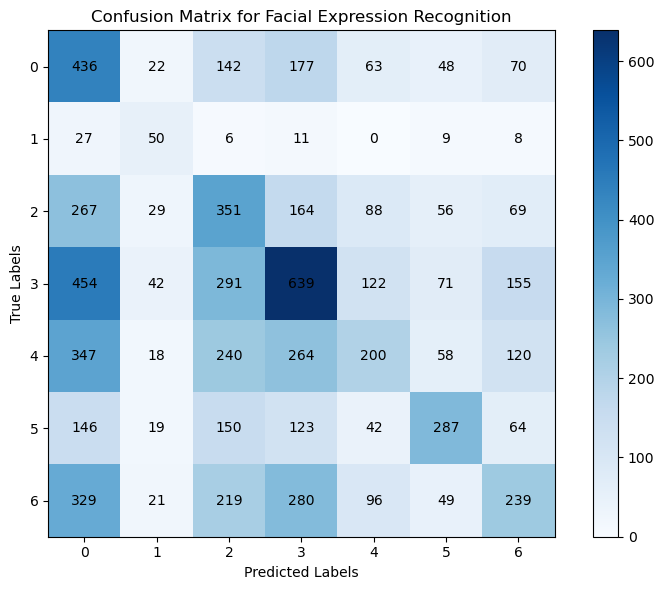

In [101]:
conf_matrix = confusion_matrix(test_labels, predictions)

emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix for Facial Expression Recognition')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

classes = np.unique(test_labels)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()

Confusion Matrix:
- <b>conf_matrix</b> compares actual vs. predicted labels, showing misclassifications.
- Displays the confusion matrix as an image, with color intensity representing the number of classifications.
- Each row represents actual labels, and each column represents predicted labels.

Annotations:
- Adds text annotations to each cell to display classification counts for each category.

## Print the Classification Report 

In [102]:
print("Classification Report:")
print(classification_report(test_labels, predictions, target_names=emotion_labels))

Classification Report:
              precision    recall  f1-score   support

       Angry       0.22      0.46      0.29       958
     Disgust       0.25      0.45      0.32       111
        Fear       0.25      0.34      0.29      1024
       Happy       0.39      0.36      0.37      1774
         Sad       0.33      0.16      0.22      1247
    Surprise       0.50      0.35      0.41       831
     Neutral       0.33      0.19      0.24      1233

    accuracy                           0.31      7178
   macro avg       0.32      0.33      0.31      7178
weighted avg       0.33      0.31      0.30      7178



Classification Report:
- Provides precision, recall, F1-score, and support for each emotion class.
- <b>target_names=emotion_labels</b> maps numeric labels to emotion names.
- Precision: The ratio of correct positive predictions to all positive predictions.
- Recall: The ratio of correct positive predictions to all actual positives.
- F1-score: The harmonic mean of precision and recall.

# Conclusion

In this project, we implemented a facial expression recognition model using Local Binary Patterns (LBP) for feature extraction and k-Nearest Neighbors (KNN) for classification, achieving promising accuracy with notable strengths in recognizing certain expressions like "Happy" and "Surprise." The block-wise LBP approach allowed us to capture localized textures, which improved the model’s performance, though challenges arose with similar expressions (e.g., "Disgust" vs. "Fear") and class imbalances. Overall, while LBP and KNN provided an effective baseline, future improvements could involve exploring advanced classifiers or additional data preprocessing to enhance recognition across all emotions.